In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, backtest
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 30
periods = 100

In [3]:
contract = pd.read_pickle('data/minute_NQ_cont_non_active_included.pickle')
contract = contract.loc['20190401':]

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

9916.21218117854

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume
label,,,,,,,
0,2019-04-01 01:31:00,7430.00,7457.25,7428.50,7453.00,5390,9817
1,2019-04-01 02:52:00,7452.75,7472.50,7450.50,7465.25,6301,10043
2,2019-04-01 04:24:00,7465.25,7479.25,7463.25,7477.75,6230,9659
3,2019-04-01 07:16:00,7477.75,7487.50,7473.25,7475.00,6320,10275
4,2019-04-01 09:17:00,7475.25,7478.25,7469.25,7472.50,5880,9943
...,...,...,...,...,...,...,...
4820,2019-09-04 17:11:00,7681.00,7686.75,7676.25,7685.50,5166,10140
4821,2019-09-04 17:28:00,7685.75,7691.00,7679.50,7688.50,4512,9468
4822,2019-09-04 17:42:00,7688.75,7702.75,7688.75,7701.25,5233,11112


In [6]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                    'close': vol_candles.close})
data['max'] = data.close.rolling(periods).max()
data['min'] = data.close.rolling(periods).min()
data['mid'] = data[['min', 'max']].mean(axis=1)
#data.set_index('date', inplace=True)
data

,date,open,close,max,min,mid
label,,,,,,
0,2019-04-01 01:31:00,7430.00,7453.00,NaN,NaN,NaN
1,2019-04-01 02:52:00,7452.75,7465.25,NaN,NaN,NaN
2,2019-04-01 04:24:00,7465.25,7477.75,NaN,NaN,NaN
3,2019-04-01 07:16:00,7477.75,7475.00,NaN,NaN,NaN
4,2019-04-01 09:17:00,7475.25,7472.50,NaN,NaN,NaN
...,...,...,...,...,...,...
4820,2019-09-04 17:11:00,7681.00,7685.50,7726.0,7594.25,7660.125
4821,2019-09-04 17:28:00,7685.75,7688.50,7726.0,7594.25,7660.125
4822,2019-09-04 17:42:00,7688.75,7701.25,7726.0,7594.25,7660.125


In [7]:
data.plot(figsize=(20,10), grid=True);

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fcc02c4d620> (for post_execute):


ValueError: view limit minimum -29570.98857638889 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -29570.98857638889 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [8]:
data['breakout'] = data['close'] - data['mid']
data['breakout_norm'] = data['breakout']/data['breakout'].rolling(periods).std()

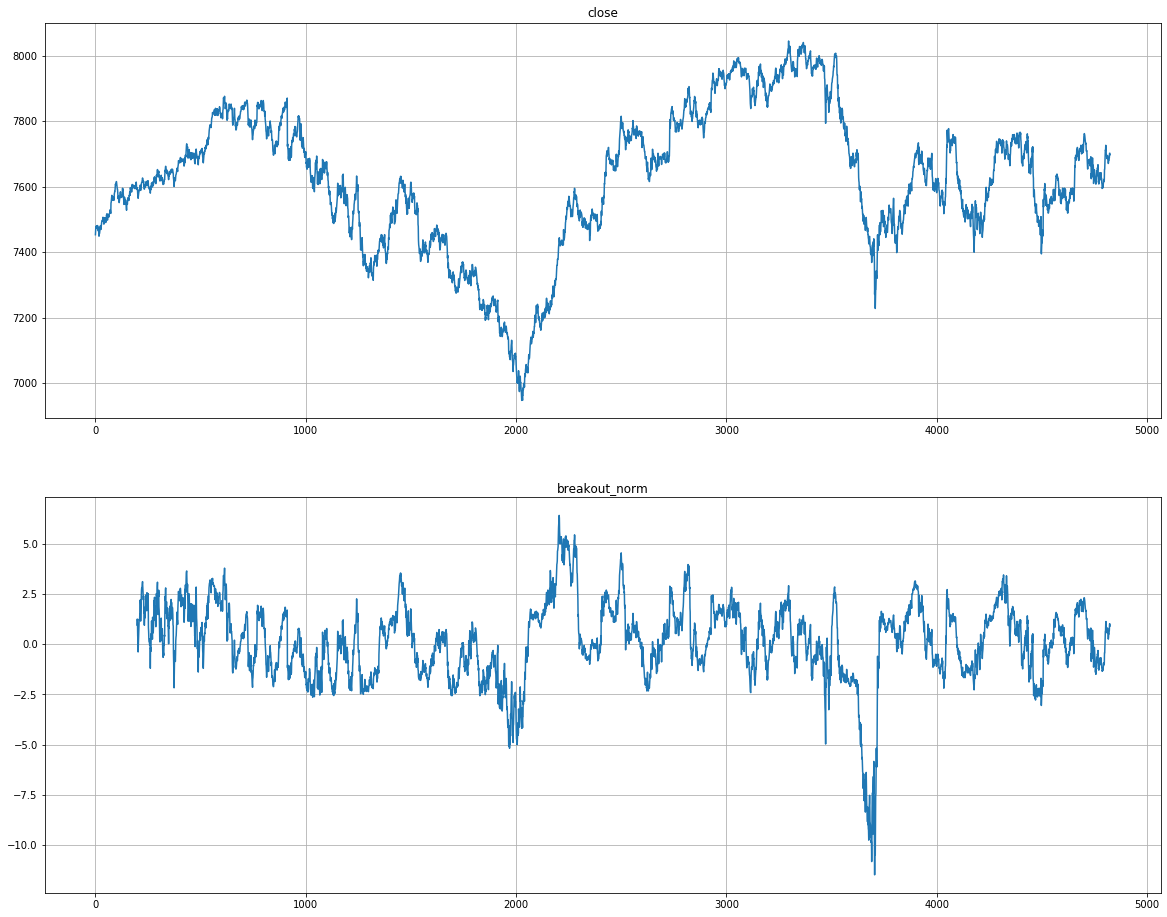

In [9]:
plot(data[['close', 'breakout_norm']])

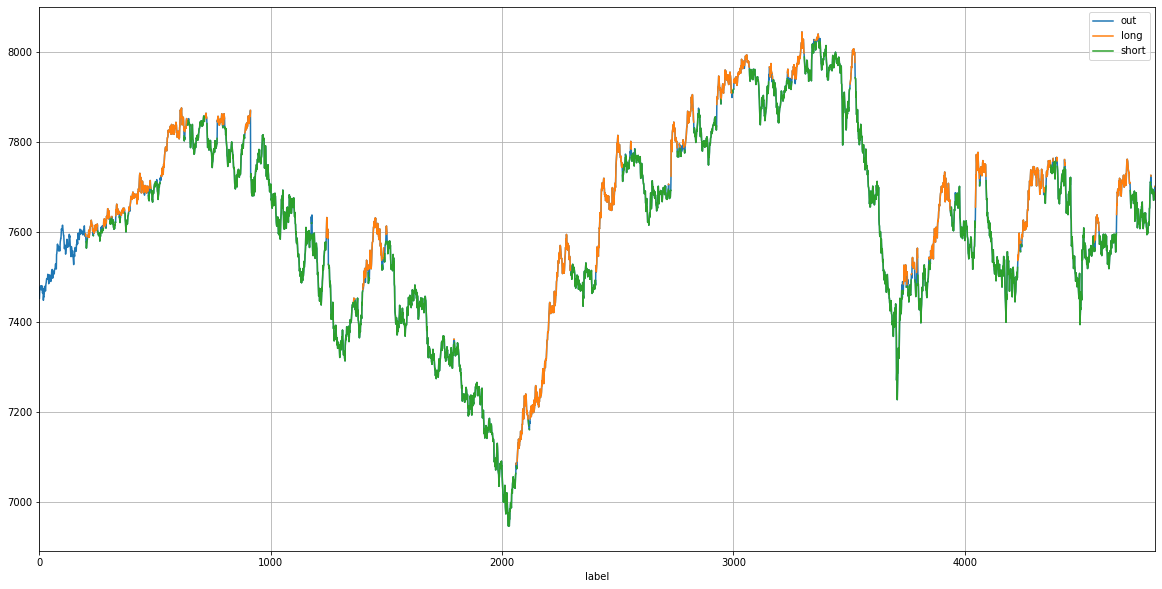

In [10]:
chart_price(data.close, data.breakout_norm, 1, 1)

In [11]:
#backtest(data.open.iloc[200:].copy(), data.breakout_norm.iloc[200:].copy(), 1, 20, 50000)

In [12]:
threshold = 1.0
test = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                     'close': data.close,
                    'breakout_norm': data.breakout_norm})
test = test.iloc[periods*2:]
test.set_index('date', inplace=True)
test['long'] = (test['breakout_norm'] > threshold) * 1
test['short'] = (test['breakout_norm'] < -threshold) * -1
test['signal'] = (test.long + test.short).shift(1)
test['signal'] = test['signal'].fillna(0)
test['position'] = test['signal'] * test['open']
test['base'] = (test['signal'] - test['signal'].shift(1)) * test.open
test['base'] = test['base'] + test['open'].shift(1) * test['signal'].shift(1)
test['base'] = test['base'].fillna(0)
test['pnl'] = test['position'] - test['base']
test

,open,close,breakout_norm,long,short,signal,position,base,pnl
date,,,,,,,,,
2019-04-08 15:29:00,7595.75,7591.50,1.113764,1,0,0.0,0.00,0.00,0.00
2019-04-08 15:34:00,7591.50,7578.00,0.405962,0,0,1.0,7591.50,7591.50,0.00
2019-04-08 15:39:00,7577.75,7576.50,0.334415,0,0,0.0,0.00,13.75,-13.75
2019-04-08 15:45:00,7576.25,7564.25,-0.386967,0,0,0.0,0.00,0.00,0.00
2019-04-08 15:52:00,7564.25,7570.00,-0.045599,0,0,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...
2019-09-04 17:11:00,7681.00,7685.50,0.619988,0,0,0.0,0.00,0.00,0.00
2019-09-04 17:28:00,7685.75,7688.50,0.694277,0,0,0.0,0.00,0.00,0.00
2019-09-04 17:42:00,7688.75,7701.25,1.004754,1,0,0.0,0.00,0.00,0.00


In [13]:
test.pnl.sum()

299.5

In [14]:
test.pnl.sum() * 50

14975.0

In [15]:
bankroll = 30000
multiplier = 50
test['pnl_dollars'] = test['pnl'] * multiplier
test['cum_pnl_dollars'] = test['pnl_dollars'].cumsum()
test['balance'] = bankroll + test['cum_pnl_dollars']
test

,open,close,breakout_norm,long,short,signal,position,base,pnl,pnl_dollars,cum_pnl_dollars,balance
date,,,,,,,,,,,,
2019-04-08 15:29:00,7595.75,7591.50,1.113764,1,0,0.0,0.00,0.00,0.00,0.0,0.0,30000.0
2019-04-08 15:34:00,7591.50,7578.00,0.405962,0,0,1.0,7591.50,7591.50,0.00,0.0,0.0,30000.0
2019-04-08 15:39:00,7577.75,7576.50,0.334415,0,0,0.0,0.00,13.75,-13.75,-687.5,-687.5,29312.5
2019-04-08 15:45:00,7576.25,7564.25,-0.386967,0,0,0.0,0.00,0.00,0.00,0.0,-687.5,29312.5
2019-04-08 15:52:00,7564.25,7570.00,-0.045599,0,0,0.0,0.00,0.00,0.00,0.0,-687.5,29312.5
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-04 17:11:00,7681.00,7685.50,0.619988,0,0,0.0,0.00,0.00,0.00,0.0,14962.5,44962.5
2019-09-04 17:28:00,7685.75,7688.50,0.694277,0,0,0.0,0.00,0.00,0.00,0.0,14962.5,44962.5
2019-09-04 17:42:00,7688.75,7701.25,1.004754,1,0,0.0,0.00,0.00,0.00,0.0,14962.5,44962.5


In [16]:
test.head(20)

,open,close,breakout_norm,long,short,signal,position,base,pnl,pnl_dollars,cum_pnl_dollars,balance
date,,,,,,,,,,,,
2019-04-08 15:29:00,7595.75,7591.50,1.113764,1,0,0.0,0.00,0.00,0.00,0.0,0.0,30000.0
2019-04-08 15:34:00,7591.50,7578.00,0.405962,0,0,1.0,7591.50,7591.50,0.00,0.0,0.0,30000.0
2019-04-08 15:39:00,7577.75,7576.50,0.334415,0,0,0.0,0.00,13.75,-13.75,-687.5,-687.5,29312.5
2019-04-08 15:45:00,7576.25,7564.25,-0.386967,0,0,0.0,0.00,0.00,0.00,0.0,-687.5,29312.5
2019-04-08 15:52:00,7564.25,7570.00,-0.045599,0,0,0.0,0.00,0.00,0.00,0.0,-687.5,29312.5
2019-04-08 15:59:00,7570.25,7576.25,0.343912,0,0,0.0,0.00,0.00,0.00,0.0,-687.5,29312.5
2019-04-08 16:10:00,7576.00,7581.75,0.700777,0,0,0.0,0.00,0.00,0.00,0.0,-687.5,29312.5
2019-04-08 16:22:00,7581.75,7584.00,0.849609,0,0,0.0,0.00,0.00,0.00,0.0,-687.5,29312.5
2019-04-08 16:31:00,7583.75,7590.00,1.238121,1,0,0.0,0.00,0.00,0.00,0.0,-687.5,29312.5


In [17]:
transactions = test[test.signal != test.signal.shift()].iloc[1:][['signal', 'cum_pnl_dollars']]
transactions['transaction_pnl'] = transactions['cum_pnl_dollars'].diff()
transactions

,signal,cum_pnl_dollars,transaction_pnl
date,,,
2019-04-08 15:34:00,1.0,0.0,NaN
2019-04-08 15:39:00,0.0,-687.5,-687.5
2019-04-08 16:41:00,1.0,-687.5,0.0
2019-04-09 15:34:00,0.0,-562.5,125.0
2019-04-09 15:43:00,1.0,-562.5,0.0
...,...,...,...
2019-09-04 00:46:00,-1.0,16575.0,0.0
2019-09-04 02:49:00,0.0,16187.5,-387.5
2019-09-04 11:16:00,1.0,16187.5,0.0


In [18]:
winning_transactions = transactions[transactions.transaction_pnl > 0]
losing_transactions = transactions[transactions.transaction_pnl < 0]
winning_percent = len(winning_transactions) / (len(winning_transactions) + len(losing_transactions))
avg_gain = winning_transactions.transaction_pnl.sum() / len(winning_transactions)
avg_loss = losing_transactions.transaction_pnl.sum() / len(losing_transactions)
ratio = abs(avg_gain / avg_loss)
ev = (winning_percent * avg_gain) + ((1 - winning_percent) * avg_loss)
winning_percent, avg_gain, avg_loss, ratio, ev

(0.24413145539906103,
 2361.298076923077,
 -669.72049689441,
 3.5257963402236534,
 70.24647887323943)

In [19]:
daily = test.balance.resample('B').last().fillna(method='ffill')
daily[daily.index[0]-pd.Timedelta(days=1)] = bankroll
daily.sort_index(inplace=True)
daily = pd.DataFrame({'balance': daily})
daily['returns'] = daily.balance.pct_change()
daily = daily.iloc[1:]
daily

,balance,returns
date,,
2019-04-08,31125.0,0.037500
2019-04-09,29450.0,-0.053815
2019-04-10,27737.5,-0.058149
2019-04-11,27000.0,-0.026589
2019-04-12,27337.5,0.012500
...,...,...
2019-08-29,50075.0,0.070264
2019-08-30,49412.5,-0.013230
2019-09-02,49412.5,0.000000


In [20]:
perf_stats(daily['returns'])

Annual return          1.572270
Cumulative returns     0.499167
Annual volatility      1.833529
Sharpe ratio           1.374066
Calmar ratio           2.503166
Stability              0.461371
Max drawdown          -0.628112
Omega ratio            1.299365
Sortino ratio          2.417545
Skew                   1.051651
Kurtosis               3.807067
Tail ratio             1.468901
Daily value at risk   -0.221005
dtype: float64

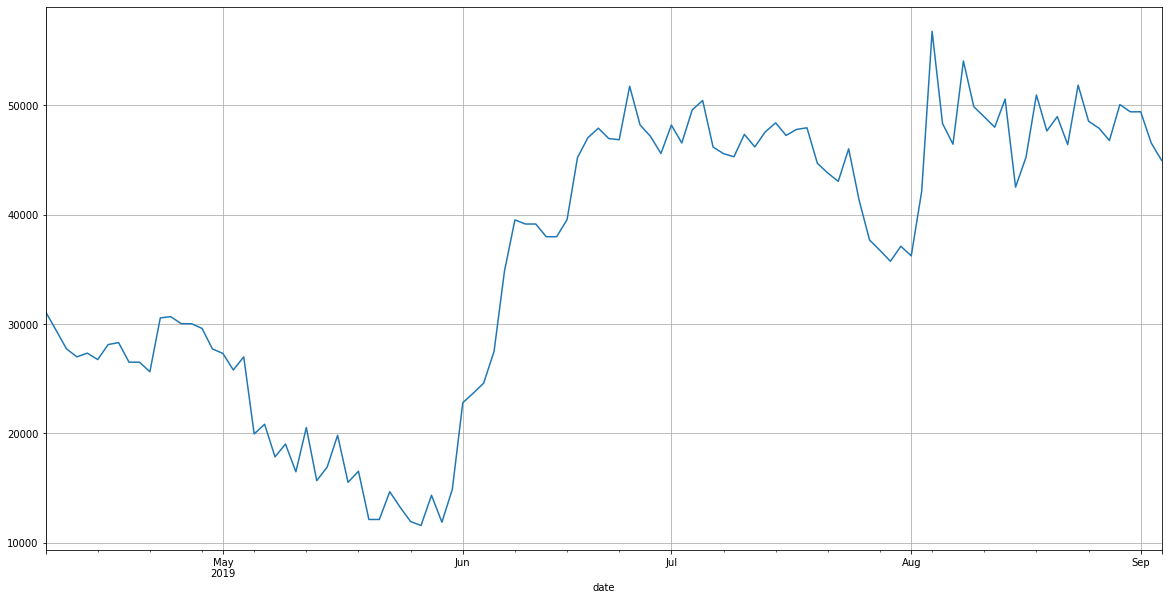

In [21]:
daily.balance.plot(figsize=(20,10), grid=True);

In [22]:
trades = test[test.signal != test.signal.shift()].signal.count()
days = daily.returns.count()
trades/days

3.9537037037037037

In [23]:
days

108